<p style="font-size:32px;text-align:center"> <b>Graph Link Prediction</b> </p>

## Importing Libraries

In [57]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd 
import datetime 
import time
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams 
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb
import networkx as nx
import pdb
from collections import Counter
import random
from sklearn.model_selection import train_test_split

In [2]:
global DATA_PATH
global PIC_PATH

DATA_PATH = "../DATA_PATH+"
PIC_PATH = "../pics/"

## Reading Graph

In [3]:
if not os.path.isfile(DATA_PATH+'after_eda/train_woheader.csv'):
    traincsv = pd.read_csv(DATA_PATH+'train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of diplicate entries: ", sum(traincsv.duplicated()))
    traincsv.to_csv(DATA_PATH+'after_eda/train_woheader.csv', header=False, index=False)
    print("saved the graph into file")

else:
    g=nx.read_edgelist(DATA_PATH+'after_eda/train_woheader.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)

    print(f'Number of nodes: {len(g.nodes)}')
    print(f'Number of edges: {len(g.edges)}')
    print(f'Average degree: {sum(dict(g.degree).values()) / len(g.nodes)}')

Number of nodes: 1862220
Number of edges: 9437519
Average degree: 10.135772357723578


Displaying a sub graph

Number of nodes: 66
Number of edges: 50
Average degree: 1.5151515151515151


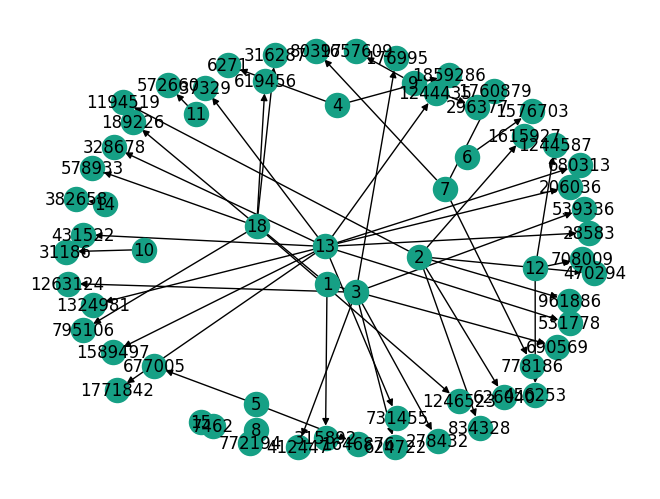

In [16]:
if not os.path.isfile(DATA_PATH+'train_woheader_sample.csv'):
    pd.read_csv(DATA_PATH+'train.csv', nrows=50)\
        .to_csv(DATA_PATH+'train_woheader_sample.csv', header=False, index=False)
    
subgraph=nx.read_edgelist(DATA_PATH+'train_woheader_sample.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)

pos=nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_color="#16A085", edge_color="#000000", width=1, edge_cmap=plt.cm.Blues, with_labels=True)

plt.savefig(PIC_PATH+"graph_sample.png", transparent=True)

print(f'Number of nodes: {len(subgraph.nodes)}')
print(f'Number of edges: {len(subgraph.edges)}')
print(f'Average degree: {sum(dict(subgraph.degree).values()) / len(subgraph.nodes)}')

# 1. Exploratory Data Analysis

In [7]:
# No of Unique persons 
print(f"The number of unique persons: {len(g.nodes())}")

The number of unique persons: 1862220


## 1.1 Number of followers for each person

In [17]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()

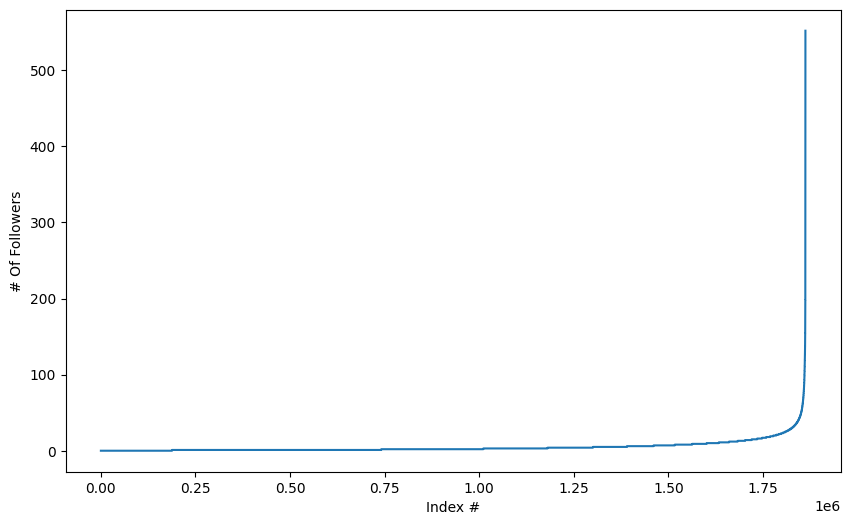

In [18]:
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index #')
plt.ylabel('# Of Followers')
plt.show()

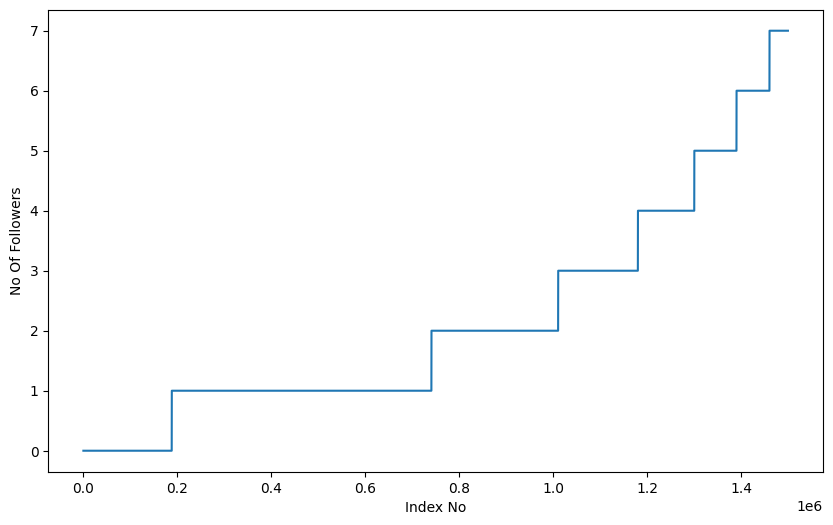

In [13]:
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index #')
plt.ylabel('# Of Followers')
plt.show()

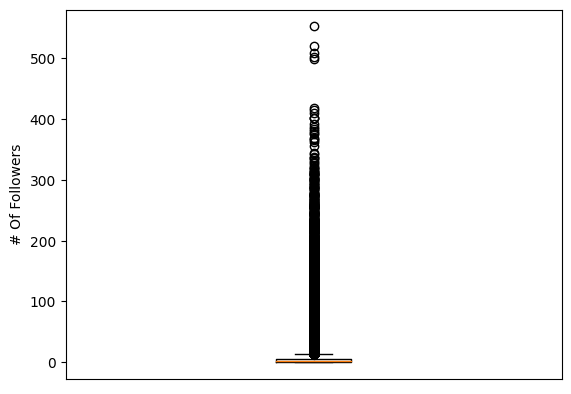

In [10]:
plt.boxplot(indegree_dist)
plt.ylabel('# Of Followers')
plt.xticks([])
plt.show()

### 90-100 percentile

In [15]:
for i in range(0,11):
    print(f"{90+i} percentile value is {np.percentile(indegree_dist,90+i)}")

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


99% of data having followers of 40 only.

### 99-100 percentile

In [12]:
for i in range(10,110,10):
    print(f"{99+(i/100)} percentile value is {np.percentile(indegree_dist,99+(i/100))}")

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


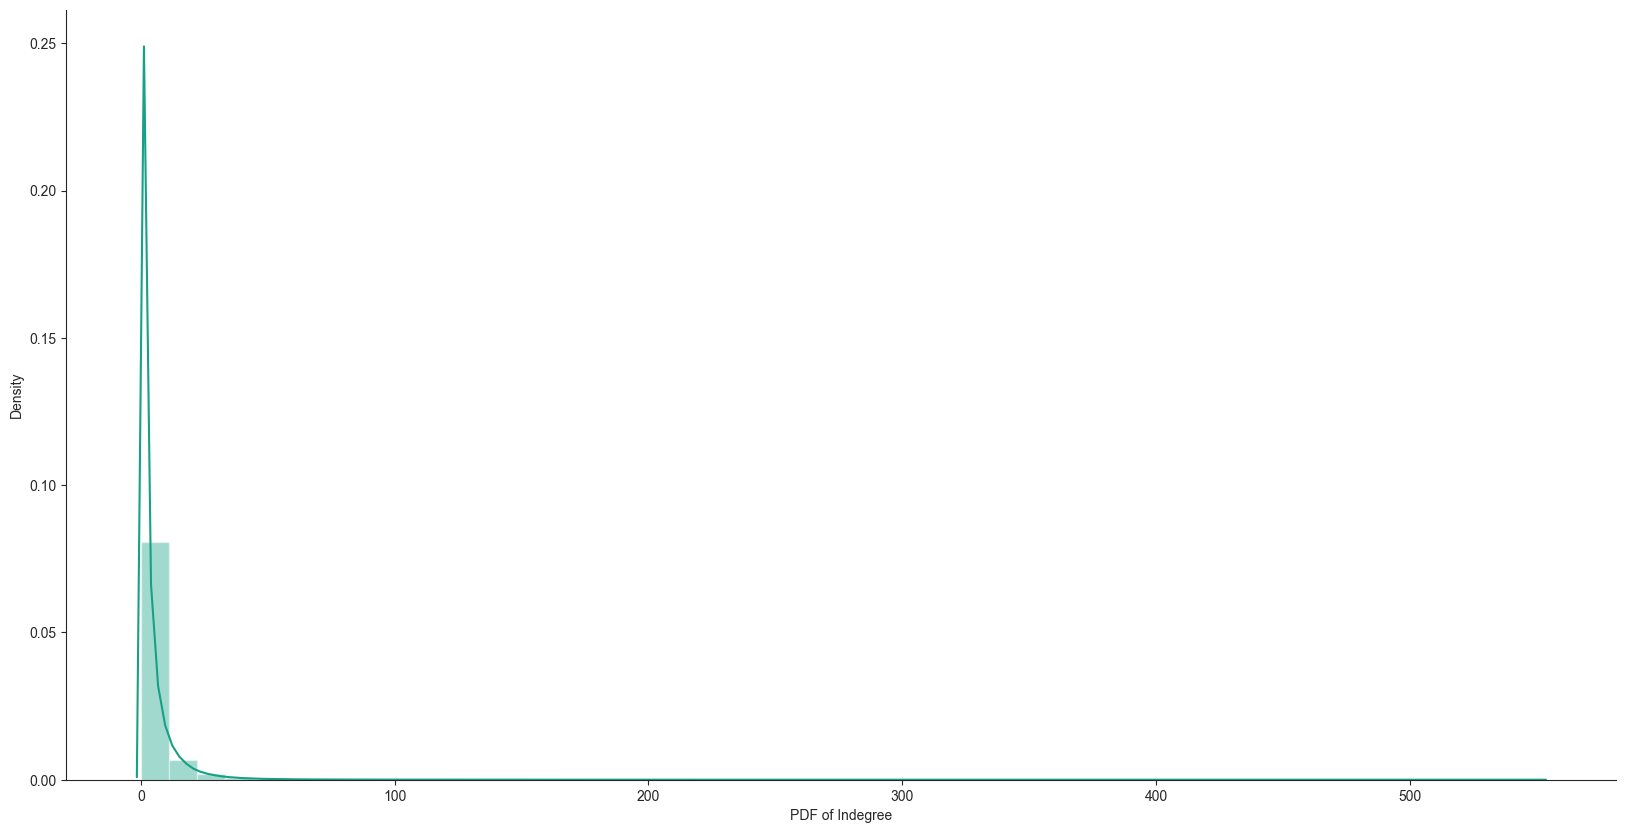

In [32]:
%matplotlib inline
sns.set_style('ticks')
plt.figure(figsize=(20,10))
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()

## 1.2 Number of people each person is following

In [19]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()

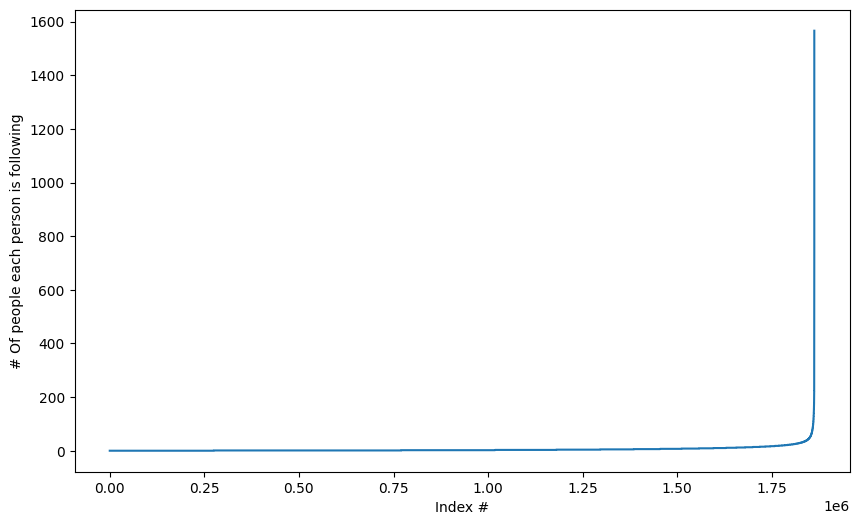

In [20]:
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index #')
plt.ylabel('# Of people each person is following')
plt.show()

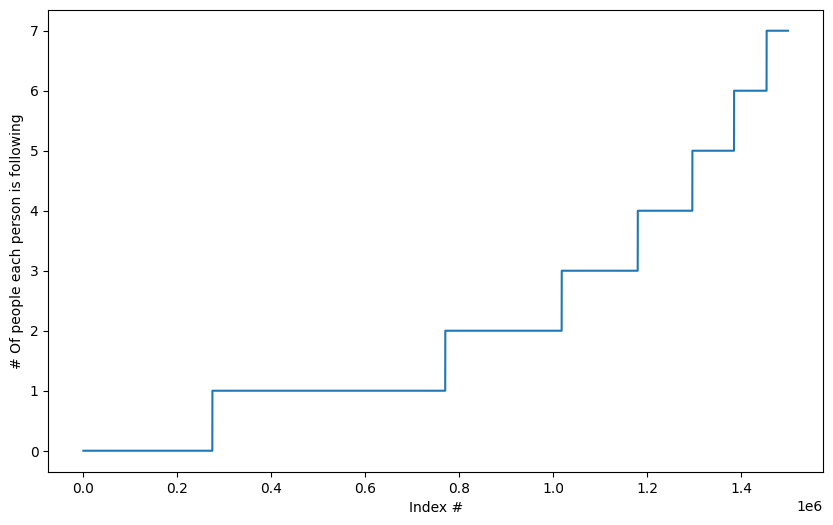

In [21]:
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index #')
plt.ylabel('# Of people each person is following')
plt.show()

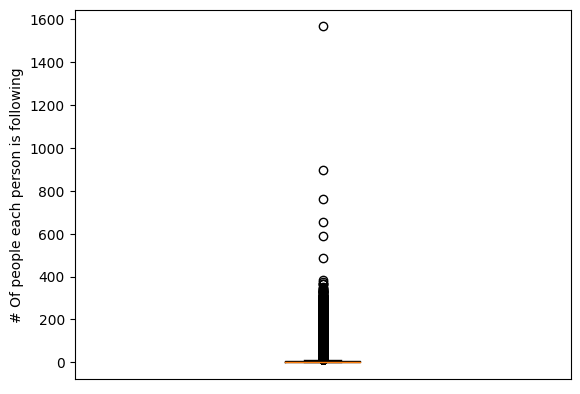

In [23]:
plt.boxplot(outdegree_dist)
plt.ylabel('# Of people each person is following')
plt.xticks([])
plt.show()

### 90-100 percentile

In [24]:
for i in range(0,11):
    print(f"{90+i} percentile value is {np.percentile(outdegree_dist,90+i)}")

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


### 99-100 percentile

In [25]:
for i in range(10,110,10):
    print(f"{99+(i/100)} percentile value is {np.percentile(outdegree_dist,99+(i/100))}")

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


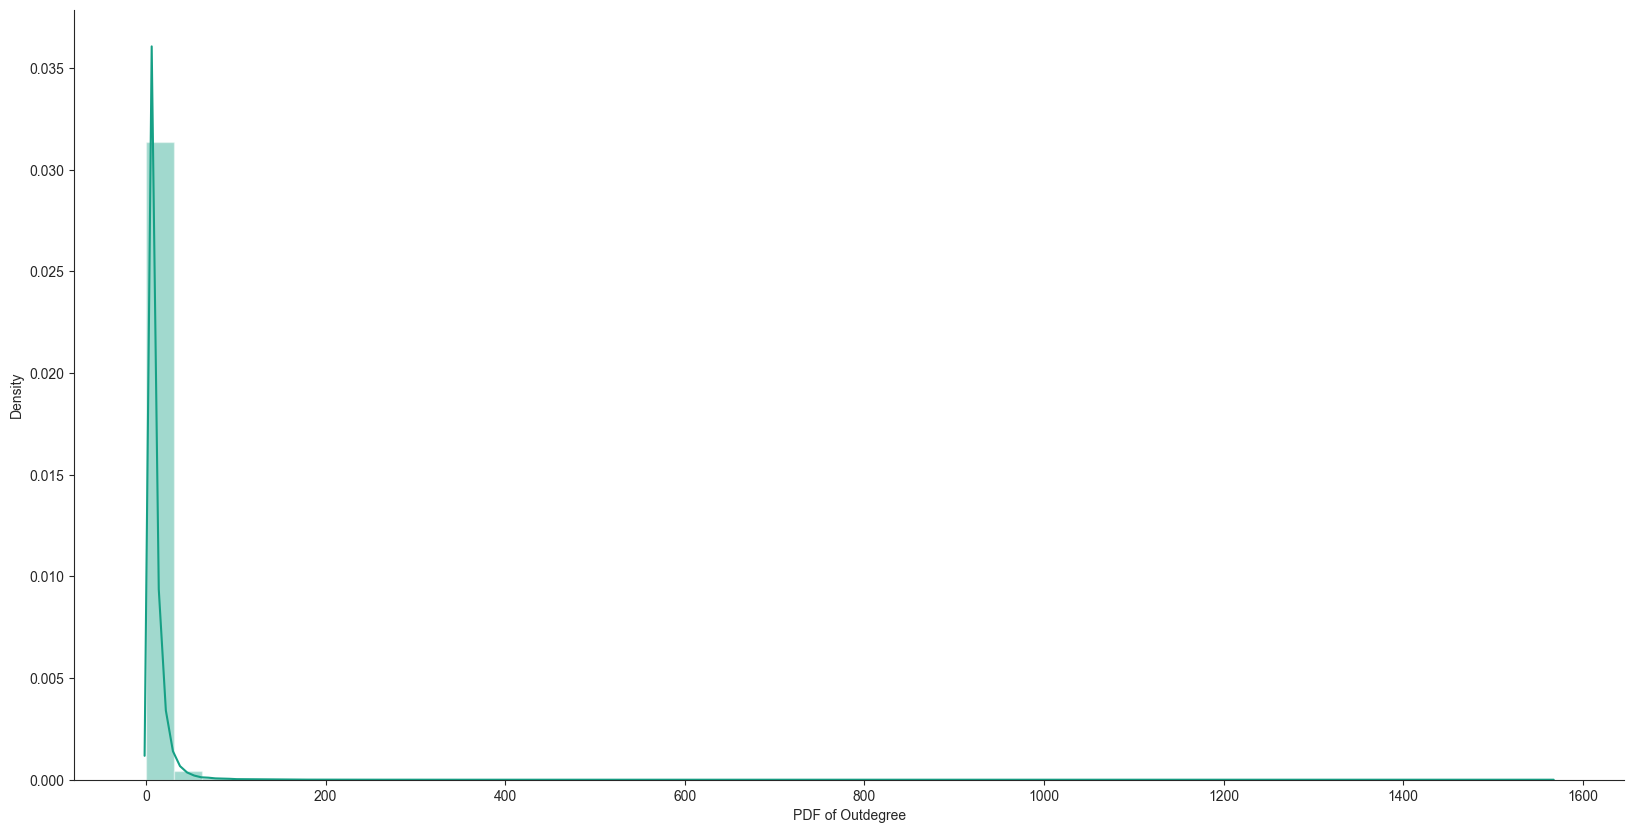

In [31]:
sns.set_style('ticks')
plt.figure(figsize=(20,10))
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

In [37]:
print(f'# of persons those are not following anyone is {sum(np.array(outdegree_dist)==0)} representing {sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist):.2f}%')

# of persons those are not following anyone are 274512 representing 14.74%


In [38]:
print(f'# of persons having zero followers is {sum(np.array(indegree_dist)==0)} representing {sum(np.array(indegree_dist)==0)*100/len(indegree_dist):.2f}%')

No of persons having zero followers are 188043 representing 10.10%


In [39]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print(f"# of people who don't follow anyone and have no followers {count}")

# of people who don't follow anyone and have no followers 0


## 1.3 Both followers + following 

In [44]:
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))
in_out_degree_sort = sorted(in_out_degree)

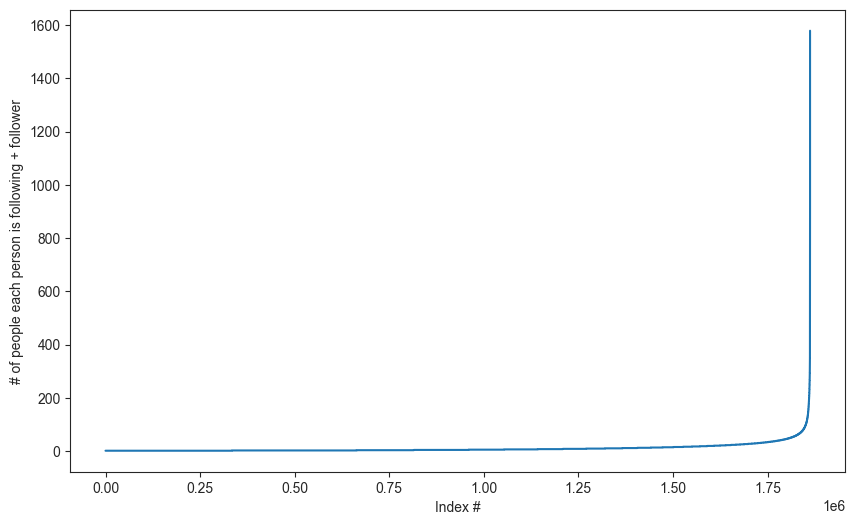

In [45]:
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index #')
plt.ylabel('# of people each person is following + follower')
plt.show()

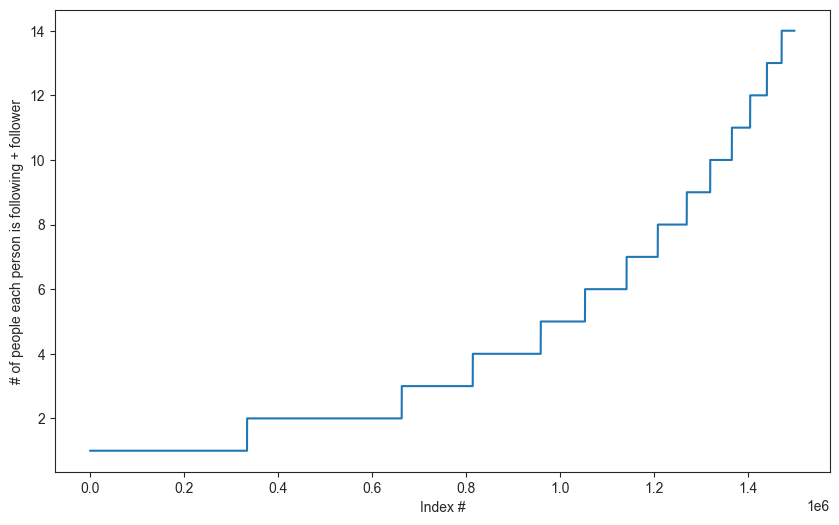

In [46]:
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index #')
plt.ylabel('# of people each person is following + follower')
plt.show()

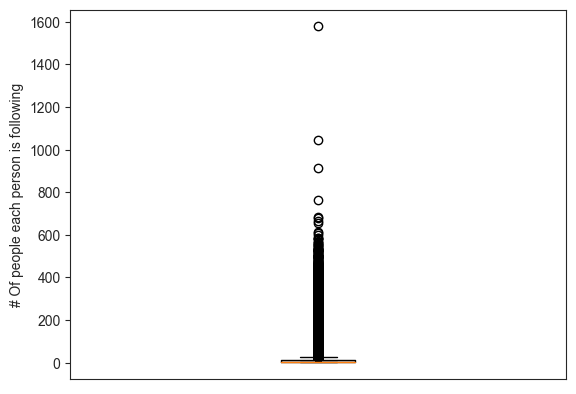

In [47]:
plt.boxplot(in_out_degree_sort)
plt.ylabel('# Of people each person is following')
plt.xticks([])
plt.show()

### 90-100 percentile

In [48]:
for i in range(0,11):
    print(f'{90+i} percentile value is: {np.percentile(in_out_degree_sort,90+i)}')

90 percentile value is: 24.0
91 percentile value is: 26.0
92 percentile value is: 28.0
93 percentile value is: 31.0
94 percentile value is: 33.0
95 percentile value is: 37.0
96 percentile value is: 41.0
97 percentile value is: 48.0
98 percentile value is: 58.0
99 percentile value is: 79.0
100 percentile value is: 1579.0


### 99-100 percentile

In [50]:
for i in range(10,110,10):
    print(f'{99+(i/100)} percentile value is: {np.percentile(in_out_degree_sort,99+(i/100))}')

99.1 percentile value is: 83.0
99.2 percentile value is: 87.0
99.3 percentile value is: 93.0
99.4 percentile value is: 99.0
99.5 percentile value is: 108.0
99.6 percentile value is: 120.0
99.7 percentile value is: 138.0
99.8 percentile value is: 168.0
99.9 percentile value is: 221.0
100.0 percentile value is: 1579.0


In [51]:
print(f'Min # of followers + following is: {in_out_degree.min()}')
print(f'{np.sum(in_out_degree==in_out_degree.min())} persons having minimum # of followers + following')

Min # of followers + following is: 1
334291 persons having minimum # of followers + following


In [52]:
print(f'Max of no of followers + following is: {in_out_degree.max()}')
print(f'{np.sum(in_out_degree==in_out_degree.max())} persons having maximum # of followers + following')

Max of no of followers + following is: 1579
1 persons having maximum # of followers + following


In [53]:
print(f'# of persons having followers + following less than 10 are {np.sum(in_out_degree<10)}')

# of persons having followers + following less than 10 are 1320326


In [55]:
print(f'# of weakly connected components: {len(list(nx.weakly_connected_components(g)))}')
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print(f'Weakly connected components wit 2 nodes: {count}')

# of weakly connected components: 45558
Weakly connected components wit 2 nodes: 32195


# 2. Posing a problem as classification problem 

## 2.1 Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 

In [64]:
%%time
if not os.path.isfile(DATA_PATH+'after_eda/missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open(DATA_PATH+'after_eda/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open(DATA_PATH+'after_eda/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open(DATA_PATH+'after_eda/missing_edges_final.p','rb'))

CPU times: total: 2.78 s
Wall time: 4.82 s


In [65]:
len(missing_edges)

9437519

## 2.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [66]:
if (not os.path.isfile(DATA_PATH+'after_eda/train_pos_after_eda.csv')) and (not os.path.isfile(DATA_PATH+'after_eda/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv(DATA_PATH+'train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print(f"Number of nodes in the graph with edges: {df_pos.shape[0]}")
    print(f"Number of nodes in the graph without edges: {df_neg.shape[0]}")
    
    #Trian test split 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*70)
    print(f"Number of nodes in the train data graph with edges: {X_train_pos.shape[0]} = {y_train_pos.shape[0]}")
    print(f"Number of nodes in the train data graph without edges: {X_train_neg.shape[0]} = {y_train_neg.shape[0]}")
    print('='*70)
    print(f"Number of nodes in the test data graph with edges: {X_test_pos.shape[0]} = {y_test_pos.shape[0]}")
    print(f"Number of nodes in the test data graph without edges: {X_test_neg.shape[0]} = {y_test_neg.shape[0]}")

    #removing header and saving
    X_train_pos.to_csv(DATA_PATH+'after_eda/train_pos_after_eda.csv', header=False, index=False)
    X_test_pos.to_csv(DATA_PATH+'after_eda/test_pos_after_eda.csv', header=False, index=False)
    X_train_neg.to_csv(DATA_PATH+'after_eda/train_neg_after_eda.csv', header=False, index=False)
    X_test_neg.to_csv(DATA_PATH+'after_eda/test_neg_after_eda.csv', header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

In [67]:
if (os.path.isfile(DATA_PATH+'after_eda/train_pos_after_eda.csv')) and (os.path.isfile(DATA_PATH+'after_eda/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist(DATA_PATH+'after_eda/train_pos_after_eda.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)
    test_graph=nx.read_edgelist(DATA_PATH+'after_eda/test_pos_after_eda.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)
    print(f'Number of nodes: {len(train_graph.nodes)}')
    print(f'Number of edges: {len(train_graph.edges)}')
    print(f'Average degree: {sum(dict(train_graph.degree).values()) / len(train_graph.nodes)}')
    print()
    print(f'Number of nodes: {len(test_graph.nodes)}')
    print(f'Number of edges: {len(test_graph.edges)}')
    print(f'Average degree: {sum(dict(test_graph.degree).values()) / len(test_graph.nodes)}')
    print()

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print(f'No of people common in train and test : {trY_teY}')
    print(f'No of people present in train but not present in test : {trY_teN}')
    print(f'No of people present in test but not present in train : {teY_trN}')
    print(f' % of people not there in Train but exist in Test in total Test data are {teY_trN/len(test_nodes_pos)*100} %')

Number of nodes: 1780722
Number of edges: 7550015
Average degree: 8.47972339309561

Number of nodes: 1144623
Number of edges: 1887504
Average degree: 3.298036121937092

No of people common in train and test : 1063125
No of people present in train but not present in test : 717597
No of people present in test but not present in train : 81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


we have a cold start problem here

In [68]:
#final train and test data sets
if (not os.path.isfile(DATA_PATH+'after_eda/train_after_eda.csv')) and \
    (not os.path.isfile(DATA_PATH+'after_eda/test_after_eda.csv')) and \
    (not os.path.isfile(DATA_PATH+'train_y.csv')) and \
    (not os.path.isfile(DATA_PATH+'test_y.csv')) and \
    (os.path.isfile(DATA_PATH+'after_eda/train_pos_after_eda.csv')) and \
    (os.path.isfile(DATA_PATH+'after_eda/test_pos_after_eda.csv')) and \
    (os.path.isfile(DATA_PATH+'after_eda/train_neg_after_eda.csv')) and \
    (os.path.isfile(DATA_PATH+'after_eda/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv(DATA_PATH+'after_eda/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv(DATA_PATH+'after_eda/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv(DATA_PATH+'after_eda/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv(DATA_PATH+'after_eda/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*70)
    print(f"Number of nodes in the train data graph with edges: {X_train_pos.shape[0]}")
    print(f"Number of nodes in the train data graph without edges: {X_train_neg.shape[0]}")
    print('='*70)
    print(f"Number of nodes in the test data graph with edges: {X_test_pos.shape[0]}")
    print(f"Number of nodes in the test data graph without edges: {X_test_neg.shape[0]}")

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv(DATA_PATH+'after_eda/train_after_eda.csv', header=False, index=False)
    X_test.to_csv(DATA_PATH+'after_eda/test_after_eda.csv', header=False, index=False)
    pd.DataFrame(y_train.astype(int)).to_csv(DATA_PATH+'train_y.csv', header=False, index=False)
    pd.DataFrame(y_test.astype(int)).to_csv(DATA_PATH+'test_y.csv', header=False, index=False)

In [ ]:
print(f"Data points in train data: {X_train.shape}")
print(f"Data points in test data: {X_test.shape}")
print(f"Shape of traget variable in train: {y_train.shape}")
print(f"Shape of traget variable in test: {y_test.shape}")